In [1]:
# 🧼 Image Deblurring with Autoencoder (Prototype)

# 📦 1. Imports
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D
from sklearn.model_selection import train_test_split

In [2]:
# 🗂️ 2. Load Sharp Images
DATASET_PATH = "../dataset/sharp"
IMG_SIZE = (64, 64)  # Small resolution for faster testing

def load_images_from_folder(folder, max_images=500):
    images = []
    for i, filename in enumerate(os.listdir(folder)):
        if i >= max_images:
            break
        img_path = os.path.join(folder, filename)
        img = cv2.imread(img_path)
        if img is not None:
            img = cv2.resize(img, IMG_SIZE)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            images.append(img)
    return np.array(images)

sharp_images = load_images_from_folder(DATASET_PATH)
sharp_images = sharp_images.astype("float32") / 255.0
print("✅ Loaded sharp images:", sharp_images.shape)

✅ Loaded sharp images: (350, 64, 64, 3)


✅ Blurred images generated: (350, 64, 64, 3)


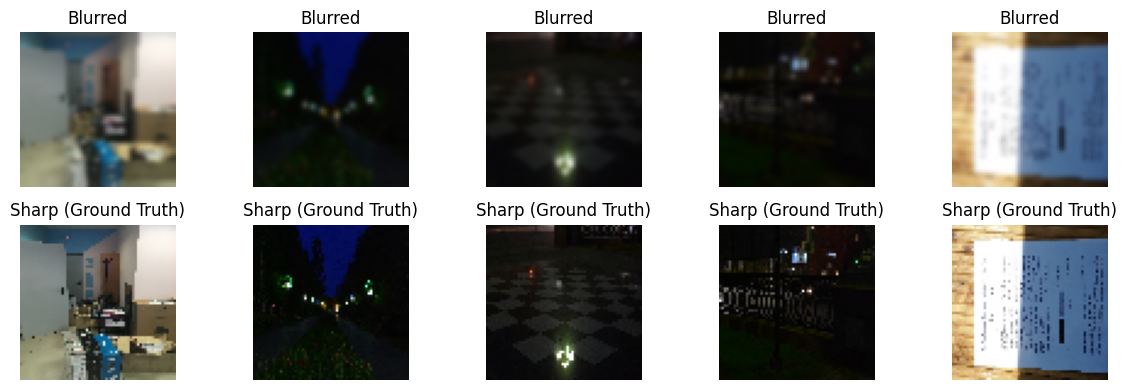

In [3]:
# 👁️ 3. Generate Blurred Images
def blur_images(images):
    blurred = []
    for img in images:
        blur = cv2.GaussianBlur(img, (5, 5), 1)
        blurred.append(blur)
    return np.array(blurred)

blurred_images = blur_images(sharp_images)
print("✅ Blurred images generated:", blurred_images.shape)

# 🔍 Show sample pairs
def show_samples(sharp, blurred, n=5):
    plt.figure(figsize=(12, 4))
    for i in range(n):
        plt.subplot(2, n, i+1)
        plt.imshow(blurred[i])
        plt.title("Blurred")
        plt.axis("off")

        plt.subplot(2, n, i+1+n)
        plt.imshow(sharp[i])
        plt.title("Sharp (Ground Truth)")
        plt.axis("off")
    plt.tight_layout()
    plt.show()

show_samples(sharp_images, blurred_images)


In [4]:
# ✂️ 4. Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(blurred_images, sharp_images, test_size=0.2, random_state=42)


In [5]:
# 🧠 5. Build Autoencoder
input_img = Input(shape=(64, 64, 3))

# Encoder
x = Conv2D(32, (3, 3), activation='relu', padding='same')(input_img)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
encoded = MaxPooling2D((2, 2), padding='same')(x)

# Decoder
x = Conv2D(64, (3, 3), activation='relu', padding='same')(encoded)
x = UpSampling2D((2, 2))(x)
x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
decoded = Conv2D(3, (3, 3), activation='sigmoid', padding='same')(x)

autoencoder = Model(input_img, decoded)
autoencoder.compile(optimizer='adam', loss='mse')

autoencoder.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 64, 64, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 64, 64, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 32, 32, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 32, 32, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 16, 16, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d (UpSampling2D)    │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 32, 32, 32)     │        18,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_1 (UpSampling2D)  │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 64, 64, 3)      │           867 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 75,651 (295.51 KB)

 Trainable params: 75,651 (295.51 KB)

 Non-trainable params: 0 (0.00 B)

In [6]:
# 🚀 6. Train Model
history = autoencoder.fit(
    X_train, y_train,
    epochs=10,
    batch_size=32,
    validation_data=(X_test, y_test)
)

Epoch 1/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 9s 274ms/step - loss: 0.0682 - val_loss: 0.0525
Epoch 2/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 147ms/step - loss: 0.0493 - val_loss: 0.0325
Epoch 3/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 167ms/step - loss: 0.0339 - val_loss: 0.0331
Epoch 4/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 149ms/step - loss: 0.0281 - val_loss: 0.0217
Epoch 5/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 150ms/step - loss: 0.0221 - val_loss: 0.0185
Epoch 6/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 144ms/step - loss: 0.0188 - val_loss: 0.0174
Epoch 7/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 150ms/step - loss: 0.0180 - val_loss: 0.0174
Epoch 8/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 150ms/step - loss: 0.0171 - val_loss: 0.0161
Epoch 9/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 137ms/step - loss: 0.0162 - val_loss: 0.0155
Epoch 10/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 153ms/step - loss: 0.0149 - val_loss: 0.0149


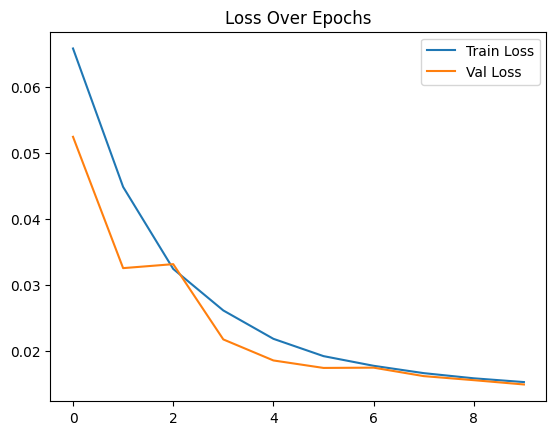

In [7]:
# 📈 7. Plot Training History
plt.plot(history.history['loss'], label="Train Loss")
plt.plot(history.history['val_loss'], label="Val Loss")
plt.legend()
plt.title("Loss Over Epochs")
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 521ms/step


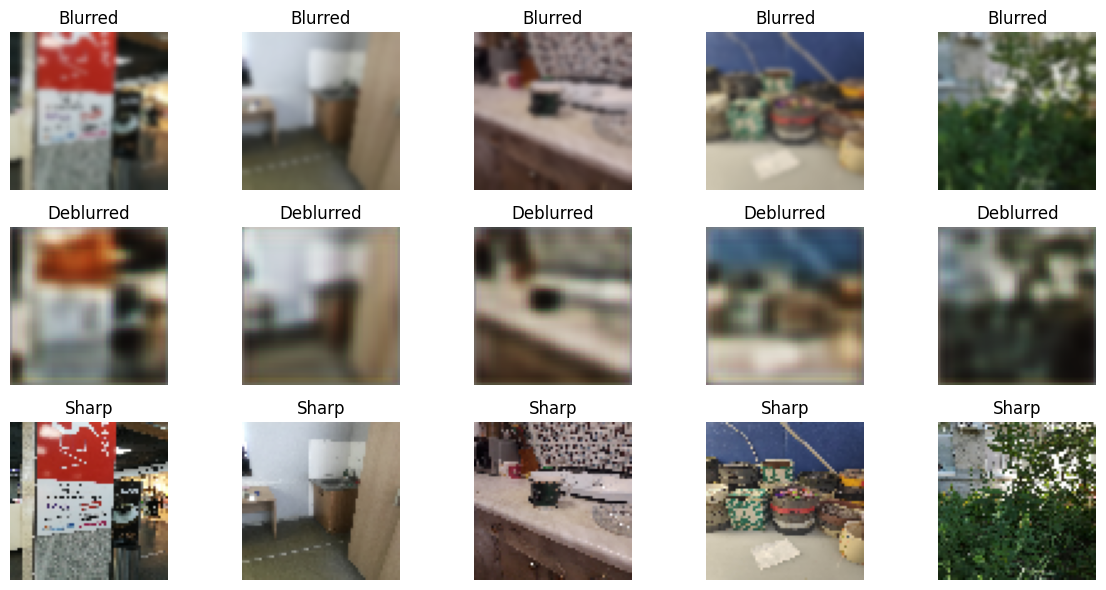

In [8]:
# 🧪 8. Visualize Predictions
def show_predictions(model, X_blur, X_true, n=5):
    preds = model.predict(X_blur[:n])
    plt.figure(figsize=(12, 6))
    for i in range(n):
        # Blurred input
        plt.subplot(3, n, i+1)
        plt.imshow(X_blur[i])
        plt.title("Blurred")
        plt.axis("off")

        # Predicted output
        plt.subplot(3, n, i+1+n)
        plt.imshow(preds[i])
        plt.title("Deblurred")
        plt.axis("off")

        # Ground truth
        plt.subplot(3, n, i+1+2*n)
        plt.imshow(X_true[i])
        plt.title("Sharp")
        plt.axis("off")
    plt.tight_layout()
    plt.show()

show_predictions(autoencoder, X_test, y_test)

In [ ]:
# 💾 9. Save Model
autoencoder.save("../saved_model/image_deblurring_autoencoder.h5")
print("✅ Model saved.")

✅ Model saved.
